In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Making fasta

In [2]:
# Read in the sanborn data and get the most active sequences
df = pd.read_table("../Pdr1/Pdr1_orthologs_w_act_sanborn.tsv", header=None)
df = df.drop([2,3,4], axis=1)
most_active = df.sort_values(5, ascending=False).head(int(len(df)*.25))

Text(0.5, 0, 'Pdr1 activity score')

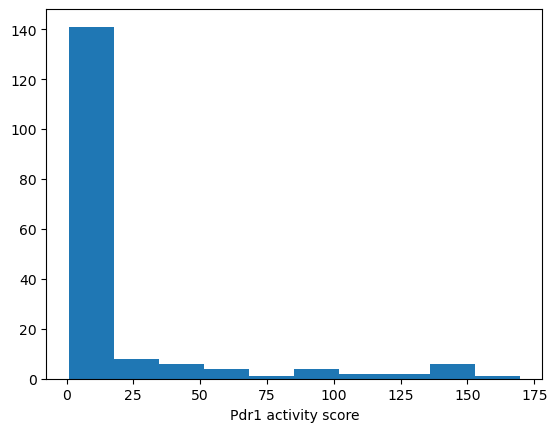

In [3]:
# Visualize distribution of activities
plt.hist(df[5])
plt.xlabel("Pdr1 activity score")

In [4]:
# Save the most active sequences as a fasta
with open("../Pdr1/pdr1_orthologs_most_active_sanborn.fasta", "w+") as f:
    for i in most_active.index:
        f.write(">" + most_active.loc[i, 0] + '\n')
        f.write(most_active.loc[i, 1] + "\n")

!mafft --auto ../Pdr1/pdr1_orthologs_most_active_sanborn.fasta > ../Pdr1/pdr1_orthologs_most_active_sanborn.mafft

# Loading the alignment

In [5]:
# Read in the alignment
with open("../Pdr1/pdr1_orthologs_most_active_sanborn.mafft", "r") as f:
    lines = f.readlines()

names = []
seqs = []
seq = ""

for line in lines:
    if line.startswith(">"):
        names.append(line.strip().replace(">",""))
        if len(seq) > 0:
            seqs.append(seq)
            seq = ""
    else:
        seq += line.strip()

seqs.append(seq)

alignment_data = pd.DataFrame({'name' : names, 'alignment' : seqs})

In [6]:
amino_acid_colors = {
    # Purples
    'F': '#FFA442',  
    'W': '#006CAF',
    'L': '#5B2B82',

    # Reds
    'D': '#E03839', 
    'E': '#FDA0A5', 

    # Blues
    'K': '#00B3E5',  # Deep sky blue
    'R': '#00B3E5',  # Blue 

    # black
    'S': '#000000',  # Gainsboro
    'P': '#000000',  # Dim grey

    # greys
    'A': '#787878',  # Lime green
    'V': '#787878',  # Light green
    'I': '#787878',  # Sea green
    'M': '#787878',  # Olive drab
    'T': '#787878',  # Silver
    'G': '#787878',  # Slate grey
    'C': '#787878',  # Burly wood
    'N': '#787878',  # Wheat
    'Q': '#787878',  # Tan
    'H': '#787878',  
    'Y': '#787878', 
    '-': "#FFFFFF"
}

In [7]:
# Code to make alignment conservation plots
def make_alignment_conservation_plot(alignment_file, output_file, remove_gaps=False):
    
    # Read in alignment file
    with open(alignment_file, "r") as f:
        lines = f.readlines()

    names = []
    seqs = []
    seq = ""

    for line in lines:
        if line.startswith(">"):
            names.append(line.strip().replace(">",""))
            if len(seq) > 0:
                seqs.append(seq)
                seq = ""
        else:
            seq += line.strip()

    seqs.append(seq)

    # This will determine the position of the amino acid in the plot (i.e. X at the bottom, - at the top)
    amino_acids = ['Y', 'H', 'Q','N', 'C', 'G', 'T', 'M', 'I', 'V', 'A', 'S',  'P', 'R', 'K', 'D', 'E', 'L', 'W', 'F', '-']

    # List of sequence positions - Each entry is a dictionary with amino acid counts at the position
    amino_acid_dicts = [{aa: 0 for aa in amino_acids}.copy() for _ in range(len(seqs[0]))]

    # Go through each sequence and count the amino acids at each position
    for seq in seqs: 
        for i, aa in enumerate(seq): 
            amino_acid_dicts[i][aa] += 1
    
    if remove_gaps: 
        filtered_aa_dict = []
        for aa_d in amino_acid_dicts:
            # Only include positions that are less than 90% gaps
            if aa_d['-'] < len(seqs) * .90:
                filtered_aa_dict.append(aa_d)
        amino_acid_dicts = filtered_aa_dict

    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(figsize=(20,3))

    for i, count_dict in enumerate(amino_acid_dicts): 
        bottom = 0

        # Add to the bar for each amino acid
        for aa, count in count_dict.items():
            p = ax.bar(i, count/len(seqs), label=aa, bottom=bottom, color = amino_acid_colors[aa])
            bottom += count/len(seqs)

    ax.set_xlabel("Alignment position")
    ax.set_ylabel("Percent of sequences")

    custom_lines = []

    # Code to add a legend
    for color in list(amino_acid_colors.values()):
        custom_lines.append(Line2D([0], [0], color=color, lw=2))

    ax.legend(custom_lines, list(amino_acid_colors.keys()), bbox_to_anchor=(1.05, 1.05), fontsize=5.5)

    plt.savefig(output_file)

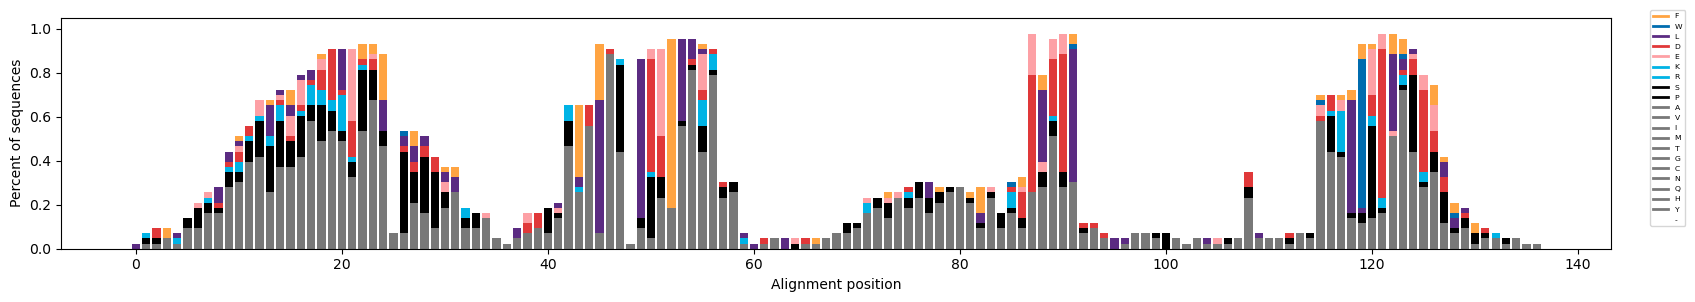

In [8]:
make_alignment_conservation_plot("../Pdr1/pdr1_orthologs_most_active_sanborn.mafft", "../Pdr1/Pdr1_alignment_conservation_plot.pdf")